## Model Characters Setting

In [1]:
# number of input image bands (in_band)
in_band = 10

# tile size
SIZE = 32

# characters for CONV layer1
OUT1 = 16
IN1= in_band
S1 = 16

# characters for CONV layer2
OUT2 = 32
IN2 = 16
S2 = 8

# characters for CONV layer3
OUT3 = 64
IN3 = 32
S3 = 4

# FPGA Board Characters Setting 

In [2]:
total_dsp = 1248*0.8  # KV260
# total_dsp = 400*0.8  # zynq7030
# total_dsp = 1728*0.8 # xczu7ev

# Model Parameters Setting

In [146]:
# Model parameters of Zynq UltraScale+
# Tile Loading
L_fresh = 18  # L: latency
n_data = 2
n_bw = 128

d1_load = 6  # d: DSP consumption
l1_load = 930  # l: LUT consumption

# Normalization
L2_norm = 5  # (l_norm - 1)
L2_enex = 2

d2_norm = 2
l2_norm = 360

# Conv_arch1
Lc1_conp = 12  # (l_conv&proc - 1)
Lc1_enex = 3
Lc1_conv = 6  # (l_conv - 1)
Lc1_pro = 10

dc1_pe = 18
lc1_pe = 890
dc1_proc = 4
lc1_proc = 380

# Conv_arch2
Lc2_conv = 6  # (l_conv - 1)
Lc2_enex1 = 4
Lc2_proc = 7  # (l_proc - 1)
Lc2_enex2 = 3

dc2_path1 = 18
lc2_path1 = 860
dc2_path2 = 4
lc2_path2 = 490

# FC_Change
L6_read = 3  # (l_read - 1)
L6_addi = 6
L6_mac = 5  # (l_mac - 1)
L6_bias = 19
L6_dist = 217

d6_mac = 2
l6_mac = 120
d6_other = 12
l6_other = 21900

## Model parameters of Zynq 7000
# L_fresh = 18
# n_data = 2
# n_bw = 128
# d1_load = 6
# l1_load = 1000

# L2_norm = 10
# L2_enex = 2
# d2_norm = 2
# l2_norm = 900

# Lc1_conp = 18
# Lc1_enex = 3
# Lc1_conv = 10
# Lc1_pro = 12
# dc1_pe = 18
# lc1_pe = 1750
# dc1_proc = 4
# lc1_proc = 730

# Lc2_conv = 11
# Lc2_enex1 = 3
# Lc2_proc = 12
# Lc2_enex2 = 3
# dc2_path1 = 18
# lc2_path1 = 1700
# dc2_path2 = 4
# lc2_path2 = 600

# L6_read = 3
# L6_addi = 6
# L6_mac = 10
# L6_bias = 23
# L6_dist = 239
# d6_mac = 2
# l6_mac = 140
# d6_other = 12
# l6_other = 21600

# Performance model for CONV Layers

In [147]:
import math
import matplotlib.pyplot as plt
import numpy as np

def dsp_latency_factors(OUT, IN, S):
    n1_all = []
    n1_all = [i for i in range(1, IN + 1) if IN % i == 0]
    for i in range(math.ceil(math.log2(IN))):
        n1_all.append(2**i)
        
    n2_all = []
    for n2_w in range(1,S):
        n2_all.append(n2_w)
    for n2_h in range(1,S+1):
        n2_all.append(n2_h*S)

    dsp_factor_2 = {}
    lut_factor_2 = {}

    for m_i2 in set(n1_all):
        for N1 in n2_all:
            for N2 in n2_all:
                M_o = 1
                M_i = m_i2
                if N1 <= S:
                    if S%N1 == 0:
                        loop1 = math.ceil(IN/M_i) * (math.ceil(S * S/N1) + Lc2_conv + Lc2_enex1)
                    else:
                        loop1 = math.ceil(IN/M_i) * S * (math.ceil(S/N1) + Lc2_conv + Lc2_enex1)
                else:
                    loop1 = math.ceil(IN/M_i) * (math.ceil(S * S/N1) + Lc2_conv + Lc2_enex1)

                if N2 <= S:
                    if S%N2 == 0:
                        loop2 = math.ceil(S * S/N2) + Lc2_proc + Lc2_enex2
                    else:
                        loop2 = S * (math.ceil(S/N2) + Lc2_proc + Lc2_enex2)
                else:
                    loop2 = math.ceil(S * S/N2) + Lc2_proc + Lc2_enex2

                lat_2 = math.ceil(OUT/M_o)*(loop1 + loop2)
                
                DSP_2 = M_o*(dc2_path1 * M_i*N1 + dc2_path2*N2) 
                LUT_2 = M_o*(lc2_path1 * M_i*N1 + lc2_path2*N2) 

                if DSP_2 in dsp_factor_2.keys():
                    if lat_2 < dsp_factor_2[DSP_2][0]:
                        dsp_factor_2[DSP_2] = (lat_2, "arch2", M_i, N1, N2)
                else:
                    dsp_factor_2[DSP_2] = (lat_2, "arch2", M_i, N1, N2)

                if LUT_2 in lut_factor_2.keys():
                    if lat_2 < lut_factor_2[LUT_2][0]:
                        lut_factor_2[LUT_2] = (lat_2, "arch2", M_i, N1, N2)
                else:
                    lut_factor_2[LUT_2] = (lat_2, "arch2", M_i, N1, N2)

    for N in n2_all:
        for m_i in set(n1_all):
            M = 1
            if (N <= S) and (S%N != 0):
                if m_i == IN:
                    lat_2 = math.ceil(OUT/M) * S * (math.ceil(S/N) + Lc1_conp + Lc1_enex)
                else:
                    lat_2 = math.ceil(OUT/M) * (math.ceil(S*S/N)) * (math.ceil(IN/m_i) + Lc1_conv + Lc1_pro)
            else:
                if m_i == IN:
                    lat_2 = math.ceil(OUT/M) * (math.ceil(S*S/N) + Lc1_conp + Lc1_enex)
                else:
                    lat_2 = math.ceil(OUT/M) * (math.ceil(S*S/N)) * (math.ceil(IN/m_i) + Lc1_conv + Lc1_pro)
                    
            DSP_2 = M*N*(dc1_pe * m_i + dc1_proc) 
            LUT_2 = M*N*(lc1_pe * m_i + lc1_proc) 

            if DSP_2 in dsp_factor_2.keys():
                if lat_2 < dsp_factor_2[DSP_2][0]:
                    dsp_factor_2[DSP_2] = (lat_2, "arch1", m_i, N)
            else:
                dsp_factor_2[DSP_2] = (lat_2, "arch1", m_i, N)

            if LUT_2 in lut_factor_2.keys():
                if lat_2 < lut_factor_2[LUT_2][0]:
                    lut_factor_2[LUT_2] = (lat_2, "arch1", m_i, N)
            else:
                lut_factor_2[LUT_2] = (lat_2, "arch1", m_i, N)

    # Stage filters to only get effective choices for CONV Layers

    index = list(dsp_factor_2.keys())
    index.sort()
    values = []
    for e in index:
        values.append(dsp_factor_2[e][0])
    result1 = [(index[i], values[i]) for i in range(len(values)) if all(values[i] <= values[j] for j in range(i))]
    x1, y1 = zip(*result1)

    index = list(lut_factor_2.keys())
    index.sort()
    values = []
    for e in index:
        values.append(lut_factor_2[e][0])
    result2 = [(index[i], values[i]) for i in range(len(values)) if all(values[i] <= values[j] for j in range(i))]
    x2, y2 = zip(*result2)

    final_dsp_factor = {}

    for e in x1:
        for n in x2:
            if dsp_factor_2[e] == lut_factor_2[n]:
                final_dsp_factor[e] = dsp_factor_2[e]

    index = list(final_dsp_factor.keys())
    index.sort()
    values = []
    for e in index:
        values.append(final_dsp_factor[e][0])

    fig, ax1 = plt.subplots(figsize=(5, 3), layout='constrained')
    # Create the plot
    ax1.plot(index, values, color='r', linestyle='--', marker = '*')

    return final_dsp_factor

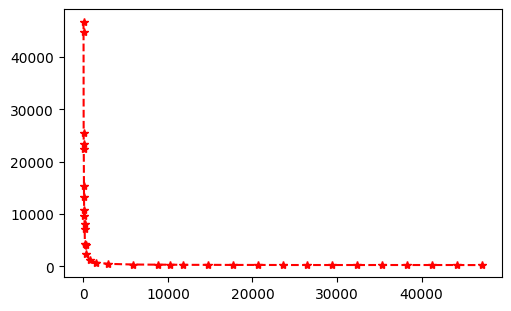

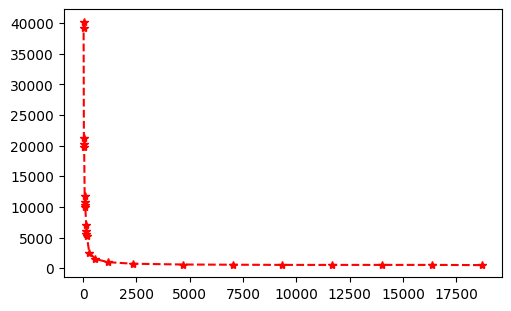

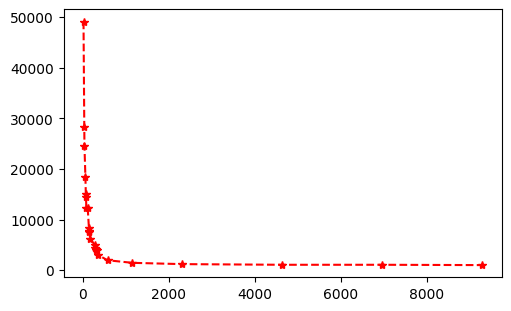

In [148]:
# Effecitve designs of three CONV layers (x-axis: DSP consumption; y-axis: stage latency)

dsp_latency1 = dsp_latency_factors(OUT1, IN1, S1) # CONV1
dsp_latency2 = dsp_latency_factors(OUT2, IN2, S2) # CONV2
dsp_latency3 = dsp_latency_factors(OUT3, IN3, S3) # CONV3

# Performance model for the maximum throughout

In [149]:
# choose 5 shortest intervals
top_5_smallest_numbers = []
# Function to insert a new number into the top 5 smallest numbers list if it's unique and among the smallest
def update_top_5(number):
    global top_5_smallest_numbers

    if number not in top_5_smallest_numbers:
        
        if len(top_5_smallest_numbers) < 5:
            top_5_smallest_numbers.append(number)
            top_5_smallest_numbers.sort() 

        else:
            if number < top_5_smallest_numbers[-1]:
                top_5_smallest_numbers[-1] = number
                top_5_smallest_numbers.sort() 

# Performance model for the target interval

In [150]:
## set target intervals for different satellites
# target_interval = 13250#9938 # 10 bands for Sentinel-2 satellite
# # target_interval = 31750 # 4 bands for SPOT satellite

In [151]:
# # choose 5 longest intervals which are shorter than target interval

# top_5_smallest_numbers = []
# # Function to insert a new number into the top 5 smallest numbers list if it's unique and among the smallest
# def update_top_5(number):
#     global top_5_smallest_numbers

#     if number <= target_interval:

#         if number not in top_5_smallest_numbers:
            
#             if len(top_5_smallest_numbers) < 5:
#                 top_5_smallest_numbers.append(number)
#                 top_5_smallest_numbers.sort(reverse=True) 

#             else:
#                 if number > top_5_smallest_numbers[-1]:
#                     top_5_smallest_numbers[-1] = number
#                     top_5_smallest_numbers.sort(reverse=True) 

## Find the 5 subsets with 5 intervals (including all stages)

In [152]:
latency = float('inf')
# Stage 1 latency
latency1 = in_band*SIZE/n_data*L_fresh + in_band*SIZE*(math.ceil(512/n_bw))
iter1 = int(SIZE/2+1)
iter2 = int(math.log2(OUT3*S3*S3)+1)
for s2 in range(0,iter1):
    for s3 in dsp_latency1:
        for s4 in dsp_latency2:
            for s5 in dsp_latency3:
                for s6 in range(0,iter2):
                    if s2==0:
                        factor2 = 1
                    else:
                        factor2 = s2*2
                    factor6 = 2**s6
                    dsp = d1_load + d2_norm*factor2 + s3 + s4 + s5 + d6_mac*factor6+d6_other
                    if dsp < total_dsp:
                        # Stage 2 latency
                        latency2 = in_band*SIZE*math.ceil(SIZE/factor2)+in_band*(L2_norm+L2_enex)
                        # Stage 3 latency
                        latency6 = 3 * ((129+L6_read)+L6_addi) + 128 * (math.ceil(1024/factor6) + L6_mac + L6_bias) + L6_dist

                        # design interval is the maximum stage latency
                        interval = max(latency1, latency2, dsp_latency1[s3][0], dsp_latency2[s4][0], dsp_latency3[s5][0], latency6)
                        update_top_5(interval)

print("The 5 smallest numbers are:", top_5_smallest_numbers)

The 5 smallest numbers are: [5312, 5568, 5751, 6080, 6144]


In [153]:
dsp_factor = {}
for e in top_5_smallest_numbers:
    dsp_factor[e] = {}
    
for s2 in range(0,iter1):
    for s3 in dsp_latency1:
        for s4 in dsp_latency2:
            for s5 in dsp_latency3:
                for s6 in range(0,iter2):
                    if s2==0:
                        factor2 = 1
                    else:
                        factor2 = s2*2
                    factor6 = 2**s6

                    latency2 = in_band*32*math.ceil(32/factor2)+in_band*(L2_norm+L2_enex)
                    latency6 = 3 * ((129+L6_read)+L6_addi) + 128 * (math.ceil(1024/factor6) + L6_mac + L6_bias) + L6_dist

                    interval = max(latency1, latency2, dsp_latency1[s3][0], dsp_latency2[s4][0], dsp_latency3[s5][0], latency6)

                    dsp = d1_load + d2_norm*factor2 + s3 + s4 + s5 + d6_mac*factor6+d6_other

                    if (interval in top_5_smallest_numbers) and (dsp < total_dsp):
                        factors = (factor2, s3, s4, s5, factor6)
                        if dsp in dsp_factor[interval].keys():
                            dsp_factor[interval][dsp].append([(d2_norm*factor2, (latency2, factor2)), (s3, dsp_latency1[s3]), (s4, dsp_latency2[s4]), (s5, dsp_latency3[s5]), (d6_mac*factor6+d6_other, (latency6, factor6))])
                        else:
                            dsp_factor[interval][dsp] = [[(d2_norm*factor2, (latency2, factor2)), (s3, dsp_latency1[s3]), (s4, dsp_latency2[s4]), (s5, dsp_latency3[s5]), (d6_mac*factor6+d6_other, (latency6, factor6))]]           

In [154]:
all_dsp = []
all_lut = []
for e in dsp_factor:
    for p in dsp_factor[e]:
        for n in dsp_factor[e][p]:
            
            lut = l1_load + l2_norm*n[0][0] + l6_mac*n[4][0] + l6_other

            if n[1][1][1] == 1:
                lut += lc2_path1*n[1][1][2]*n[1][1][3] + lc2_path2*n[1][1][4]
            else:
                lut += n[1][1][3] * (lc1_pe*n[1][1][2] + lc1_proc)

            if n[2][1][1] == 1:
                lut += lc2_path1*n[2][1][2]*n[2][1][3] + lc2_path2*n[2][1][4]
            else:
                lut += n[2][1][3] * (lc1_pe*n[2][1][2] + lc1_proc)
                
            if n[3][1][1] == 1:
                lut += lc2_path1*n[3][1][2]*n[3][1][3] + lc2_path2*n[3][1][4]
            else:
                lut += n[3][1][3] * (lc1_pe*n[3][1][2] + lc1_proc)
                
            all_dsp.append(p)
            all_lut.append(lut)

## Choose the design with min Complexity Score in each subset

In [155]:
i = 0
min_dsp = min(all_dsp)
max_dsp = max(all_dsp)
min_lut = min(all_lut)
max_lut = max(all_lut)
for e in dsp_factor:
    for p in dsp_factor[e]:
        for n in dsp_factor[e][p]:
            n.append(((all_lut[i]-min_lut)/(max_lut-min_lut))+((all_dsp[i]-min_dsp)/(max_dsp-min_dsp)))
            i = i+1

print("Potential design intervals:")
dsp_factor.keys()

Potential design intervals:


dict_keys([5312, 5568, 5751, 6080, 6144])

In [156]:
final_dsp_lut_factor = {}
for e in dsp_factor:
    score = []
    for p in dsp_factor[e]:
        for n in dsp_factor[e][p]:
            score.append(n[5])
    for p in dsp_factor[e]:
        for n in dsp_factor[e][p]:
            if n[5] == min(score):
                final_dsp_lut_factor[e] = p, n

print("Stage 1 Latency:", latency1, "; DSP comsumption:", d1_load)
final_dsp_lut_factor
# Design interval: 5312: (Total DSP consumption: 930,
#   [Stage 2: (DSP consumption: 4, (latency: 5190, N: 2)),
#    Stage 3: (DSP consumption: 184, (latency: 4336, 'arch1', Nin: 10, Ns: 1)),
#    Stage 4: (DSP consumption: 176, (latency: 5312, 'arch2', Nin: 8, N1s: 1, N2s: 8)),
#    Stage 5: (DSP consumption: 292, (latency: 4992, 'arch2', Nin: 16, N1s: 1, N2s:1)),
#    Stage 6: (DSP consumption: 268, (latency: 4727, N: 128)),
#    Complexity Score: 0.8991673172001041])

Stage 1 Latency: 4160.0 ; DSP comsumption: 6


{5312: (930,
  [(4, (5190, 2)),
   (184, (4336, 'arch1', 10, 1)),
   (176, (5312, 'arch2', 8, 1, 8)),
   (292, (4992, 'arch2', 16, 1, 1)),
   (268, (4727, 128)),
   1.238455346551432]),
 5568: (914,
  [(4, (5190, 2)),
   (184, (4336, 'arch1', 10, 1)),
   (160, (5568, 'arch2', 8, 1, 4)),
   (292, (4992, 'arch2', 16, 1, 1)),
   (268, (4727, 128)),
   1.1908362989323844]),
 5751: (786,
  [(4, (5190, 2)),
   (184, (4336, 'arch1', 10, 1)),
   (160, (5568, 'arch2', 8, 1, 4)),
   (292, (4992, 'arch2', 16, 1, 1)),
   (140, (5751, 64)),
   0.4682469073038468]),
 6080: (778,
  [(4, (5190, 2)),
   (184, (4336, 'arch1', 10, 1)),
   (152, (6080, 'arch2', 8, 1, 2)),
   (292, (4992, 'arch2', 16, 1, 1)),
   (140, (5751, 64)),
   0.444437383494323]),
 6144: (662,
  [(4, (5190, 2)),
   (184, (4336, 'arch1', 10, 1)),
   (152, (6080, 'arch2', 8, 1, 2)),
   (176, (6144, 'arch1', 1, 8)),
   (140, (5751, 64)),
   0.0])}